# Contrastive CLIP Reward Estimator

This notebook upgrades the original CLIP‑based reward head by **adding a negative prompt**.  
The reward is the sigmoid‑scaled difference between the cosine similarity of the frame with a **positive** prompt
(*“a red Kong dog toy centered in the frame”*) and a **negative** prompt
(*“an empty kitchen floor with no toy”*).

A centred red Kong should yield rewards ≳ 0.8, while frames with no toy (or off‑centre toy) drop ≲ 0.2.


In [7]:
import os, random, torch, json
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

import config                                   # project‑level config
from importnb import Notebook
with Notebook():
    from jetbot_dataset import JetbotDataset    # same dataset class as before

device = torch.device(config.DEVICE)
print("Using device ➜", device)

# ----------------------------------------------------------------------
# Load CLIP model (ViT‑B/32 for speed; switch to ViT‑L/14 if you have VRAM)
# ----------------------------------------------------------------------
MODEL_NAME = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(MODEL_NAME)
clip_model = CLIPModel.from_pretrained(MODEL_NAME).eval().to(device)

# ----------------------------------------------------------------------
# Encode positive & negative text prompts ONCE
# ----------------------------------------------------------------------
POS_PROMPT = "a red Kong dog toy centered in the frame"
NEG_PROMPT = "an empty kitchen floor with no toy"

with torch.no_grad():
    pos_emb = clip_model.get_text_features(**processor(text=POS_PROMPT, return_tensors="pt").to(device)).float()
    pos_emb /= pos_emb.norm(p=2, dim=-1, keepdim=True)

    neg_emb = clip_model.get_text_features(**processor(text=NEG_PROMPT, return_tensors="pt").to(device)).float()
    neg_emb /= neg_emb.norm(p=2, dim=-1, keepdim=True)

print("Positive & negative text embeddings ready.")

Using device ➜ cuda
Positive & negative text embeddings ready.


In [8]:
def clip_reward(pil_img, tau: float = 3.0):
    """Contrastive CLIP reward ∈[0,1].
    1 ⇒ Kong centred; 0 ⇒ empty floor or off‑centre.

    Args:

        pil_img (PIL.Image): input RGB frame

        tau (float): temperature / scaling of the sigmoid; higher = steeper

    """
    with torch.no_grad():
        inputs  = processor(images=pil_img, return_tensors="pt").to(device)
        img_emb = clip_model.get_image_features(**inputs).float()
        img_emb /= img_emb.norm(p=2, dim=-1, keepdim=True)

        delta = (img_emb @ pos_emb.T) - (img_emb @ neg_emb.T)   # (1,1)
        return torch.sigmoid(tau * delta).item()

In [9]:
# ----------------------------------------------------------------------
# Load your Jetbot dataset exactly as before
# ----------------------------------------------------------------------
IMAGE_SIZE    = config.IMAGE_SIZE
N_PREV_FRAMES = config.NUM_PREV_FRAMES

TRANSFORM = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])

dataset = JetbotDataset(
    csv_path=config.CSV_PATH,
    data_dir=config.DATA_DIR,
    image_size=IMAGE_SIZE,
    num_prev_frames=N_PREV_FRAMES,
    transform=TRANSFORM,
    seed=42,
)
print("Dataset length:", len(dataset))

Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037
Dataset length: 23037


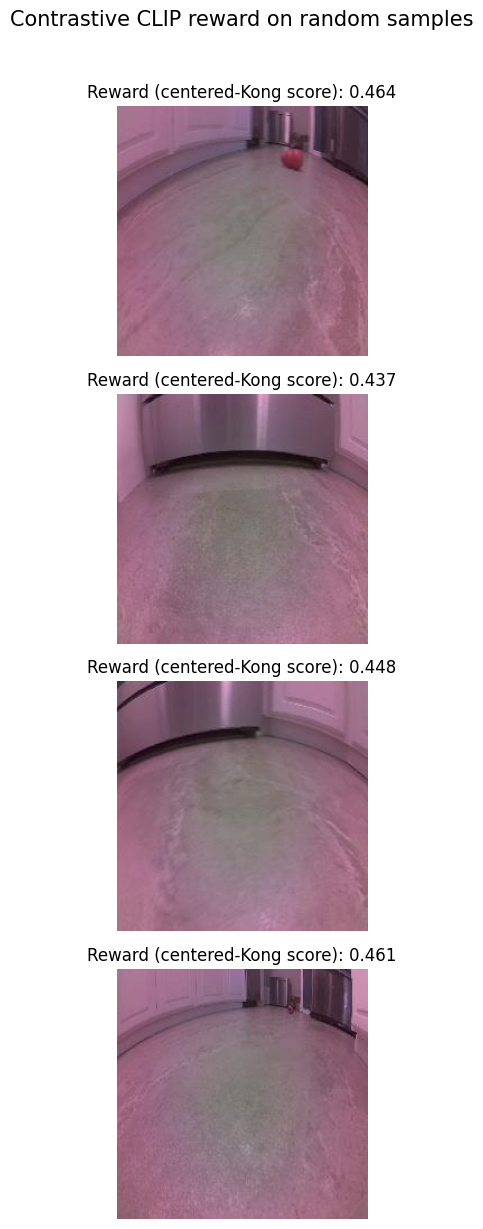

In [10]:
def show_clip_rewards(ds, n=6, title="Contrastive CLIP reward on random samples"):
    idxs = random.sample(range(len(ds)), n)
    plt.figure(figsize=(6, 3*n))
    for i, idx in enumerate(idxs):
        curr_img, _, _ = ds[idx]           # JetbotDataset returns (curr, r, prev)
        pil_img = T.ToPILImage()(curr_img)
        r = clip_reward(pil_img)

        plt.subplot(n, 1, i+1)
        plt.imshow(pil_img)
        plt.axis(False)
        plt.title(f"Reward (centered‑Kong score): {r:.3f}")
    plt.suptitle(title, y=1.02, fontsize=15)
    plt.tight_layout()
    plt.show()

# 🔍 Try it on a few random frames
show_clip_rewards(dataset, n=4)

## (Optional) Live JetBot Reward Stream
Uncomment and adapt the next cell to stream frames from your real JetBot and display the contrastive reward in real time.

In [ ]:
# from jetbot_remote_client import RemoteJetBot
# import ipywidgets as widgets, asyncio, cv2
#
# JETBOT_IP  = "192.168.68.52"          # change to your robot's IP
# REFRESH_HZ = 15
#
# bot = RemoteJetBot(JETBOT_IP)
# print("Connected to JetBot at", JETBOT_IP)
#
# reward_label = widgets.Label(value="Reward: ---")
# display(reward_label)
#
# async def live_loop():
#     while True:
#         bgr = bot.get_frame()
#         if bgr is not None:
#             rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
#             pil  = Image.fromarray(rgb)
#             r = clip_reward(pil_img=pil)
#             reward_label.value = f"Reward: {r:.3f}"
#         await asyncio.sleep(1 / REFRESH_HZ)
#
# await live_loop()